In [26]:
sys.path.append("..")
import utils
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings("ignore")
colors = sns.color_palette("Set1")
sns.set_style('ticks')

In [27]:
def get_paths(relative_dir = "results/weighted_09jun/"):
    paths = os.listdir("../" + relative_dir)
    rel_paths = []
    for i in range(len(paths)):
        if not (paths[i] == '.DS_Store' or paths[i] == 'archive'):
            rel_paths.append(relative_dir + paths[i])
    return rel_paths

In [28]:
def find_policy_name(path):
    string = path.split("_")[2]
    if string == 'susceptible':
        return "Population-Based"
    if string == 'infection':
        return "Infection-Based"
    if string == 'random':
        return "Random"
    if string == 'oldest':
        return "Age-Based"
    if string == 'contact':
        return "Contact-Based"
    if string == 'fhi':
        return "NIPH"
    return "ETP"

In [29]:
paths = get_paths()
results = {}
counter=1
for relative_path in paths:
    key = find_policy_name(relative_path)
    if key=="ETP":
        key += f" nr. {counter}"
        counter += 1
    results[key] = utils.read_csv(relative_path=relative_path)

100%|██████████| 200/200 [00:08<00:00, 23.99it/s]


In [ ]:
 def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

<Figure size 432x288 with 0 Axes>

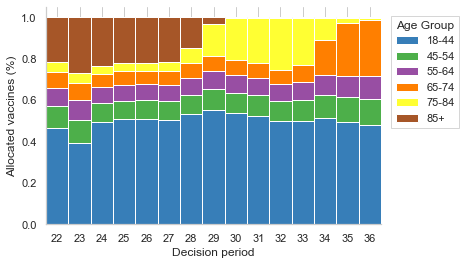

<Figure size 432x288 with 0 Axes>

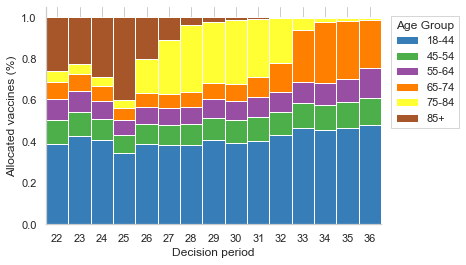

<Figure size 432x288 with 0 Axes>

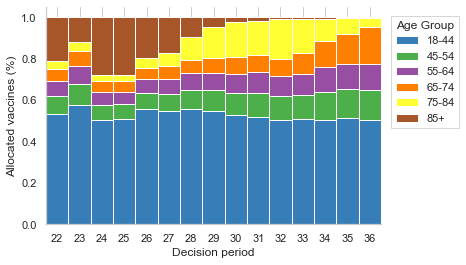

<Figure size 432x288 with 0 Axes>

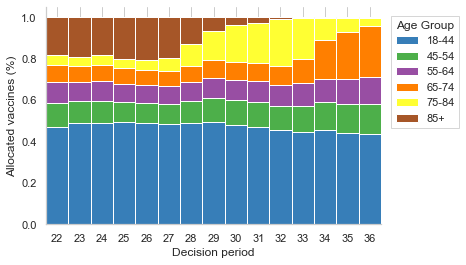

In [49]:
paths = get_paths()
keys = list(results.keys())

for i in range(len(keys)):
    age_labels = results[keys[i]][0]
    vaccinated_age_groups = results[keys[i]][-2]
    vaccinated_age_groups = np.diff(vaccinated_age_groups, axis=1)
    vaccinated_mean = vaccinated_age_groups.mean(axis=0)
    week_cut = 22 #Where vaccines are available
    norm = np.where(np.int64(vaccinated_mean.sum(axis=1, keepdims=True))==0, 1, vaccinated_mean.sum(axis=1, keepdims=True))
    vaccinated_mean[week_cut:].sum(axis=1)
    vaccinated_proportions = np.divide(vaccinated_mean, norm)
    vaccinated_proportions[week_cut:].sum(axis=1)
    vaccinated_cumsum = vaccinated_mean.cumsum(axis=1)
    weeks = np.arange(vaccinated_proportions.shape[0])
    df = pd.DataFrame(columns=age_labels[1:], data=vaccinated_proportions[week_cut:,1:], index=weeks[week_cut:])
    plt.figure()
    ax = df.plot(kind='bar', stacked=True, color=colors[1:],)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    change_width(ax, 1)
    lgd = plt.legend(title="Age Group",loc='right', bbox_to_anchor=(1.25, 0.7), ncol=1, fancybox=False)
    plt.xticks(rotation=0)
    plt.xlabel("Decision period")
    plt.ylabel("Allocated vaccines (%)")
    plt.savefig(f"../plots/vaccination/random_individuals/{keys[i]}_vaccination_by_age.png", dpi=200, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [30]:
nr_sim = results[list(results.keys())[0]][4].shape[0]
objective_values = {}
for keys in results.keys():
    objective_values[keys] = np.zeros((nr_sim,5)) #axis 1: index 0: deaths, 1: infected, 2: yll, 3: vaccinated, 4: weighted

In [31]:
paths = utils.create_named_tuple('paths', 'filepaths.txt')
config = utils.create_named_tuple('config', "../"+paths.config)

for key in list(results.keys()):
    print("Finding objective values for ", key)
    result = results[key]
    age_labels = result[0]
    
    new_deaths_age_groups = result[-3]
    cumulative_deaths = new_deaths_age_groups.cumsum(axis=1)
    cum_deaths = np.zeros((cumulative_deaths.shape[0], cumulative_deaths.shape[2]))
    yll = np.zeros((cumulative_deaths.shape[0]))
    for i in range(cumulative_deaths.shape[0]):
        cum_deaths[i] = cumulative_deaths[i,-1,:]
        yll[i] = utils.calculate_yll(utils.get_expected_yll(config.age_bins, age_labels),  cum_deaths[i]) 
    deaths = np.sum(cum_deaths, axis=1)

    new_infected_age_groups = result[-4]
    cumulative_infected = new_infected_age_groups.cumsum(axis=1)
    infected = np.zeros((cumulative_infected.shape[0]))
    for i in range(cumulative_infected.shape[0]):
        infected[i] = np.sum(cumulative_infected[i,-1,:])

    vaccinated_age_groups = result[-2]
    vaccinated = np.zeros((vaccinated_age_groups.shape[0]))
    for i in range(vaccinated_age_groups.shape[0]):
        vaccinated[i] = np.sum(vaccinated_age_groups[i,-1,:])

    weighted = np.zeros((cumulative_infected.shape[0]))
    for i in range(cumulative_deaths.shape[0]):
        weighted[i] = 0.01*infected[i] + deaths[i]
        

    objective_values[key][:,0] = deaths
    objective_values[key][:,1] = infected
    objective_values[key][:,2] = yll
    objective_values[key][:,3] = vaccinated
    objective_values[key][:,4] = weighted

Finding objective values for  ETP nr. 1
Finding objective values for  ETP nr. 2
Finding objective values for  ETP nr. 3
Finding objective values for  ETP nr. 4


In [59]:
def density_plot(values, key, color):
    # Draw the density plot
    ax = sns.distplot(values, hist=False, kde=True,
                 kde_kws={'linewidth': 0.8},
                 label=key, color=color)
    ax.set(yticklabels=[])
    ax.set(xlabel=None, ylabel=None)
    mean = np.mean(values)
    ax.vlines(mean, 0, ymax = ax.lines[-1].get_ydata().max()*0.9725, color=color, ls='-', lw=0.8)
    return ax

Deaths

Infected

YLL

Weighted



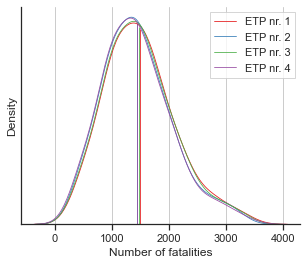

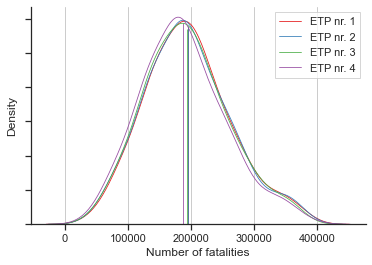

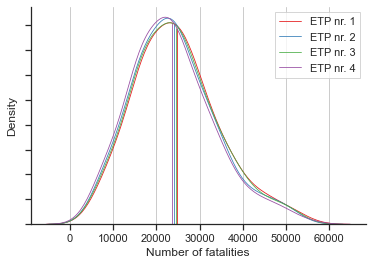

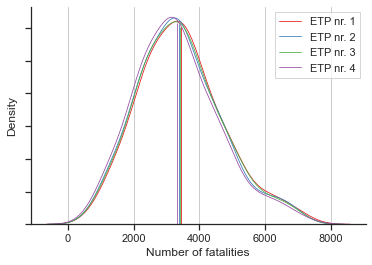

In [70]:
keys = list(results.keys())
print("Deaths")
print()
plt.figure(figsize=(5,4))
sns.set_style('ticks')
for n in range(len(keys)):
    ax = density_plot(objective_values[keys[n]][:,0], keys[n], colors[n])
plt.legend(loc='upper right', ncol=1, fancybox=False, shadow=False)
plt.xlabel('Number of fatalities')
plt.ylabel("Density")
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
ax.xaxis.grid()
plt.savefig("../plots/computational_study/weighted_significance/random_fatalities_distributions.png", dpi=200)

print("Infected")
print()
plt.figure()
for n in range(len(keys)): 
    ax = density_plot(objective_values[keys[n]][:,1], keys[n], colors[n])
plt.legend(loc='upper right', ncol=1, fancybox=False, shadow=False)
plt.xlabel('Number of fatalities')
plt.ylabel("Density")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
ax.xaxis.grid()
plt.savefig("../plots/computational_study/weighted_significance/random_infected_distributions.png", dpi=200)


print("YLL")
print()
plt.figure()
for n in range(len(keys)): 
    ax = density_plot(objective_values[keys[n]][:,2], keys[n], colors[n])
plt.legend(loc='upper right', ncol=1, fancybox=False, shadow=False)
plt.xlabel('Number of fatalities')
plt.ylabel("Density")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
ax.xaxis.grid()
plt.savefig("../plots/computational_study/weighted_significance/random_yll_distributions.png", dpi=200)

print("Weighted")
print()
plt.figure()
for n in range(len(keys)): 
    ax = density_plot(objective_values[keys[n]][:,4], keys[n], colors[n])
plt.legend(loc='upper right', ncol=1, fancybox=False, shadow=False)
plt.xlabel('Number of fatalities')
plt.ylabel("Density")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
ax.xaxis.grid()
plt.savefig("../plots/computational_study/weighted_significance/random_weighted_distributions.png", dpi=200)

In [34]:
def t_test(first, second):
        """ Performs one-sided t-test to check to variables for significant difference

        Args:
            first (Individual): presumed best individual
            second (Individual): presumed worse individual
            significance (float, optional): level of significance to test against. Defaults to 0.1.

        Returns:
            bool: True if significance is achieved
        """
        if not (first==second).all():
            z = first - second
            return scipy.stats.ttest_ind(z, np.zeros(len(first)), alternative="less").pvalue
        return 1

In [35]:
dead = dict(map(lambda x: (x[0], np.array(x[1])[:,0]), objective_values.items()))
infected = dict(map(lambda x: (x[0], np.array(x[1])[:,1]), objective_values.items()))
yll = dict(map(lambda x: (x[0], np.array(x[1])[:,2]), objective_values.items()))
vaccinated = dict(map(lambda x: (x[0], np.array(x[1])[:,3]), objective_values.items()))
weighted = dict(map(lambda x: (x[0], np.array(x[1])[:,0] + 0.01*np.array(x[1])[:,1]), objective_values.items()))

mean_dead = dict(map(lambda x: (x[0], np.mean(np.array(x[1])[:,0])), objective_values.items()))
mean_infected = dict(map(lambda x: (x[0], np.mean(np.array(x[1])[:,1])), objective_values.items()))
mean_yll = dict(map(lambda x: (x[0], np.mean(np.array(x[1])[:,2])), objective_values.items()))
mean_vaccinated = dict(map(lambda x: (x[0], np.mean(np.array(x[1])[:,3])), objective_values.items()))
mean_weighted = dict(map(lambda x: (x[0], np.mean(np.array(x[1])[:,0] + 0.01*np.array(x[1])[:,1])), objective_values.items()))

sorted_dead = dict(sorted(mean_dead.items(), key=lambda x: x[1]))
sorted_infected = dict(sorted(mean_infected.items(), key=lambda x: x[1]))
sorted_yll = dict(sorted(mean_yll.items(), key=lambda x: x[1]))
sorted_vaccinated = dict(sorted(mean_vaccinated.items(), key=lambda x: x[1]))
sorted_weighted = dict(sorted(mean_weighted.items(), key=lambda x: x[1]))
 
std_dead = dict(map(lambda x: (x[0], np.std(np.array(x[1])[:,0])), objective_values.items()))
std_infected = dict(map(lambda x: (x[0], np.std(np.array(x[1])[:,1])), objective_values.items()))
std_yll = dict(map(lambda x: (x[0], np.std(np.array(x[1])[:,2])), objective_values.items()))
std_vaccinated = dict(map(lambda x: (x[0], np.std(np.array(x[1])[:,3])), objective_values.items()))
std_weighted = dict(map(lambda x: (x[0], np.std(np.array(x[1])[:,0] + 0.01*np.array(x[1])[:,1])), objective_values.items()))


In [36]:
print()
print("Dead")
keys = list(sorted_dead.keys())
for key in keys:
    print(f"{key:>20} {mean_dead[key]:>8,.0f} {std_dead[key]:>8,.0f} {std_dead[key]/mean_dead[key]:>8,.2f}")
print()
print()
print("Infected")
for key in keys:
    print(f"{key:>20} {mean_infected[key]:>8,.0f} {std_infected[key]:>8,.0f} {std_infected[key]/mean_infected[key]:>8,.2f}")
print()
print()
print("YLL")
for key in keys:
    print(f"{key:>20} {mean_yll[key]:>8,.0f} {std_yll[key]:>8,.0f} {std_yll[key]/mean_yll[key]:>8,.2f}")
print()
print()
print("Vaccinated")
for key in keys:
    print(f"{key:>20} {mean_vaccinated[key]:>8,.0f} {std_vaccinated[key]:>8,.0f} {std_vaccinated[key]/mean_vaccinated[key]:>8,.2f}")

print()
print()
print("Weighted Objective")
for key in keys:
    print(f"{key:>20} {mean_weighted[key]:>8,.0f} {std_weighted[key]:>8,.0f} {std_weighted[key]/mean_weighted[key]:>8,.2f}")


Dead
           ETP nr. 4    1,439      609     0.42
           ETP nr. 2    1,451      605     0.42
           ETP nr. 3    1,484      613     0.41
           ETP nr. 1    1,499      618     0.41


Infected
           ETP nr. 4  187,642   66,699     0.36
           ETP nr. 2  194,564   67,448     0.35
           ETP nr. 3  192,986   66,604     0.35
           ETP nr. 1  195,463   67,118     0.34


YLL
           ETP nr. 4   23,560    9,659     0.41
           ETP nr. 2   24,099    9,680     0.40
           ETP nr. 3   24,428    9,736     0.40
           ETP nr. 1   24,703    9,801     0.40


Vaccinated
           ETP nr. 4 2,199,948   72,015     0.03
           ETP nr. 2 2,271,854   60,058     0.03
           ETP nr. 3 2,354,498   41,870     0.02
           ETP nr. 1 2,304,023   34,027     0.01


Weighted Objective
           ETP nr. 4    3,315    1,272     0.38
           ETP nr. 2    3,396    1,276     0.38
           ETP nr. 3    3,414    1,276     0.37
           ETP nr. 1    3,4

In [37]:
solution1 = 0
solution2 = 1

print("solution 1", list(sorted_dead.keys())[solution1])
print("solution 2", list(sorted_dead.keys())[solution2])

solution 1 ETP nr. 4
solution 2 ETP nr. 2


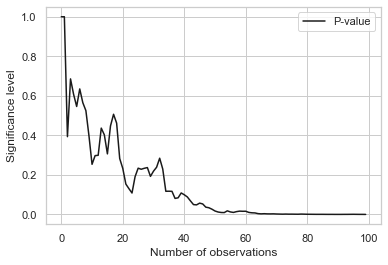

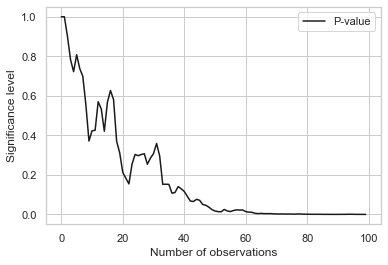

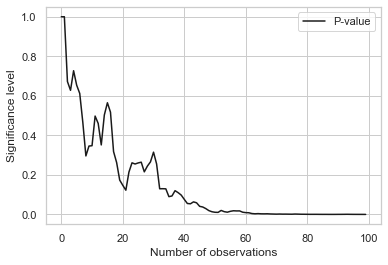

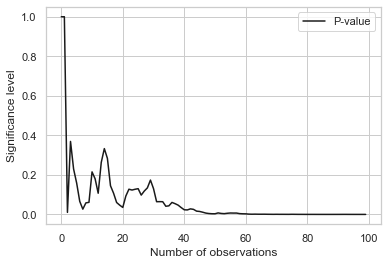

In [63]:
for cut_off in range(74,78):
    objective_value_best = objective_values[list(sorted_dead.keys())[solution1]][cut_off:cut_off+100,0]
    objective_value_second_best = objective_values[list(sorted_dead.keys())[solution2]][cut_off:cut_off+100,0]
    p_values = np.zeros(len(objective_value_best))
    observations = np.arange(len(objective_value_best))
    for i in range(len(objective_value_best)-1):
        p_values[i] = t_test(objective_value_best[:i], objective_value_second_best[:i])
    p_values[np.isnan(p_values)] = 1

    sns.set()
    sns.set_style("whitegrid")
    sns.lineplot(observations, p_values, label="P-value", color='k')
    plt.xlabel("Number of observations")
    plt.ylabel("Significance level")
    #plt.savefig("../plots/computational_study/weighted_significance/random_fatalities_significance.png", dpi=200)
    plt.show()
    plt.close()

In [62]:
"""
for cut_off in range(0,80):
    objective_value_best = objective_values[list(sorted_infected.keys())[solution1]][cut_off:,1]
    objective_value_second_best = objective_values[list(sorted_infected.keys())[solution2]][cut_off:,1]

    p_values = np.zeros(len(objective_value_best))
    observations = np.arange(len(objective_value_best))
    for i in range(len(objective_value_best)-1):
        p_values[i] = t_test(objective_value_best[:i], objective_value_second_best[:i])
    p_values[np.isnan(p_values)] = 1

    sns.set()
    sns.set_style("whitegrid")
    sns.lineplot(observations, p_values, label="P-value", color='k')
    plt.xlabel("Number of observations")
    plt.ylabel("Significance level")
    #plt.savefig("../plots/computational_study/weighted_significance/random_infected_significance.png", dpi=200)
    plt.show()
    plt.close()
"""

'\nfor cut_off in range(0,80):\n    objective_value_best = objective_values[list(sorted_infected.keys())[solution1]][cut_off:,1]\n    objective_value_second_best = objective_values[list(sorted_infected.keys())[solution2]][cut_off:,1]\n\n    p_values = np.zeros(len(objective_value_best))\n    observations = np.arange(len(objective_value_best))\n    for i in range(len(objective_value_best)-1):\n        p_values[i] = t_test(objective_value_best[:i], objective_value_second_best[:i])\n    p_values[np.isnan(p_values)] = 1\n\n    sns.set()\n    sns.set_style("whitegrid")\n    sns.lineplot(observations, p_values, label="P-value", color=\'k\')\n    plt.xlabel("Number of observations")\n    plt.ylabel("Significance level")\n    #plt.savefig("../plots/computational_study/weighted_significance/random_infected_significance.png", dpi=200)\n    plt.show()\n    plt.close()\n'

In [61]:
"""
for cut_off in range(0,80):
    objective_value_best = objective_values[list(sorted_yll.keys())[solution1]][cut_off:,2]
    objective_value_second_best = objective_values[list(sorted_yll.keys())[solution2]][cut_off:,2]
    p_values = np.zeros(len(objective_value_best))
    observations = np.arange(len(objective_value_best))
    for i in range(len(objective_value_best)):
        p_values[i] = t_test(objective_value_best[:i], objective_value_second_best[:i])
    p_values[np.isnan(p_values)] = 1

    sns.set()
    sns.set_style("whitegrid")
    sns.lineplot(observations, p_values, label="P-value", color='k')
    plt.xlabel("Number of observations")
    plt.ylabel("Significance level")
    #plt.savefig("../plots/computational_study/weighted_significance/random_yll_significance.png", dpi=200)
    plt.show()
    plt.close()
"""    

'\nfor cut_off in range(0,80):\n    objective_value_best = objective_values[list(sorted_yll.keys())[solution1]][cut_off:,2]\n    objective_value_second_best = objective_values[list(sorted_yll.keys())[solution2]][cut_off:,2]\n    p_values = np.zeros(len(objective_value_best))\n    observations = np.arange(len(objective_value_best))\n    for i in range(len(objective_value_best)):\n        p_values[i] = t_test(objective_value_best[:i], objective_value_second_best[:i])\n    p_values[np.isnan(p_values)] = 1\n\n    sns.set()\n    sns.set_style("whitegrid")\n    sns.lineplot(observations, p_values, label="P-value", color=\'k\')\n    plt.xlabel("Number of observations")\n    plt.ylabel("Significance level")\n    #plt.savefig("../plots/computational_study/weighted_significance/random_yll_significance.png", dpi=200)\n    plt.show()\n    plt.close()\n'

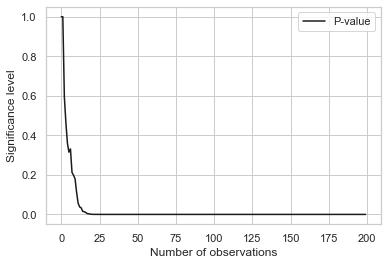

In [41]:
objective_value_best = objective_values[list(sorted_weighted.keys())[solution1]][:,4]
objective_value_second_best = objective_values[list(sorted_weighted.keys())[solution2]][:,4]
p_values = np.zeros(len(objective_value_best))
observations = np.arange(len(objective_value_best))
for i in range(len(objective_value_best)-1):
    p_values[i] = t_test(objective_value_best[:i], objective_value_second_best[:i])
p_values[np.isnan(p_values)] = 1

sns.set()
sns.set_style("whitegrid")
sns.lineplot(observations, p_values, label="P-value", color='k')
plt.xlabel("Number of observations")
plt.ylabel("Significance level")
plt.savefig("../plots/computational_study/weighted_significance/random_weighted_significance.png", dpi=200)

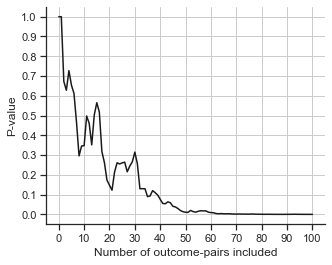

In [75]:
objective_value_best = objective_values[list(sorted_dead.keys())[solution1]][76:,0]
objective_value_second_best = objective_values[list(sorted_dead.keys())[solution2]][76:,0]

p_values = np.zeros(len(objective_value_best))
observations = np.arange(len(objective_value_best))
for i in range(len(objective_value_best)-1):
    p_values[i] = t_test(objective_value_best[:i], objective_value_second_best[:i])
p_values[np.isnan(p_values)] = 1

plt.figure(figsize=(5,4))
ax = sns.lineplot(observations[:101], p_values[:101], color='k')
plt.xticks(observations[0:101:10])
plt.yticks([0.1*i for i in range(11)])
plt.xlabel("Number of outcome-pairs included")
plt.ylabel("P-value")
sns.set_style('ticks')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid()
plt.savefig("../plots/computational_study/weighted_significance/random_fatalities_significance_narrowed.png", dpi=200)

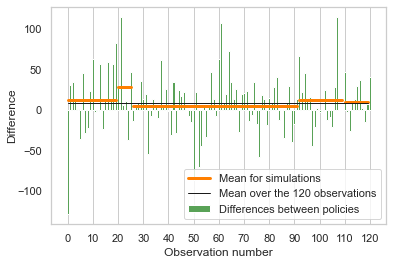

In [43]:
observations = np.arange(len(objective_value_best))
diffs = np.arange(len(objective_value_best))
for i in range( len(objective_value_best)-1):
   diffs[i] = objective_value_second_best[i] - objective_value_best[i]

l1 = 20  #limit 1
l2 = 26  #limit 2
l3 = 92  #limit 3
l4 = 110  #limit 4
l5 = 120  #limit 5


sns.set_style("whitegrid")
ax = sns.barplot(observations[:l5+1], diffs[:l5+1], label = "Differences between policies", color=colors[2], dodge=False)
sns.lineplot(observations[:l1], np.mean(diffs[:l1]), label = "Mean for simulations", linewidth=3, color=colors[4], ax=ax)
sns.lineplot(observations[l1:l2], np.mean(diffs[l1:l2]), linewidth=3, color=colors[4], ax=ax)
sns.lineplot(observations[l2:l3], np.mean(diffs[l2:l3]), linewidth=3, color=colors[4], ax=ax)
sns.lineplot(observations[l3:l4], np.mean(diffs[l3:l4]), linewidth=3, color=colors[4], ax=ax)
sns.lineplot(observations[l4:l5], np.mean(diffs[l4:l5]), linewidth=3, color=colors[4], ax=ax)
sns.lineplot(observations[:l5], np.mean(diffs[:l5]), label = f"Mean over the {l5} observations", linewidth=1, color='k', ax=ax)
plt.xticks(observations[:l5+1:10])
plt.xlabel("Observation number")
plt.grid()
ax.set_ylabel("Difference", labelpad=0)
plt.savefig("../plots/computational_study/weighted_significance/fatalities_diffs.png", dpi=200)

In [44]:
np.mean(diffs[:l5])

9.108333333333333